##Author 
****
Karen Rugerio Armenta

## Business case
****
Calibrate an ARIMA-SARIMA model for the series of the GLOBAL INDEX OF ECONOMIC ACTIVITY of Mexico to obtain a forecast of the Mexican economy until september 2024.

## Case Description
****
Perform statistical tests of stationarity and decide the type of transformation of the variable.

Calibrates an ARIMA-SARIMA model based on autocorrelation tests and plots. Clearly explain the calibration process and the reason of the parameter modifications.
Interpret the calibrated model coefficients and their statistical significance.

Makes a prediction of the variable with a 24-month projection using the calibrated model.



#Importing Libraries

In [1139]:
#Libraries
import warnings
#warnings.simplefilter(action='ignore')
import pandas as pd              
import matplotlib.pyplot as plt   
import numpy as np                
import math
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Dataframe creation

In [1140]:
#Extraction
from google.colab import drive
drive.mount("/content/gdrive")  
%cd "/content/gdrive/MyDrive/Colab Notebooks/Bloque2/Dorantes/Dataset"
np.set_printoptions(suppress=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Colab Notebooks/Bloque2/Dorantes/Dataset


In [1141]:
#DataFrame creation
df = pd.read_csv('Indicadores.csv')
#Rename columns so we have everything in English 
df = df.rename(columns={'Periodo':'Period','Valor':'Value'})
#Modifying Period data type, as we have an object and we need 
#datetime to work with it
df['Period'] = pd.to_datetime(df['Period'])
#Defining a monthly period and obtaining a YYYYMM format
#df['Period'] = df['Period'].dt.to_period('M')
df

,Period,Value
0,1993-01-01,60.407691
1,1993-02-01,61.022521
2,1993-03-01,63.943249
3,1993-04-01,61.865984
4,1993-05-01,63.612900
...,...,...
350,2022-03-01,111.940152
351,2022-04-01,109.529866
352,2022-05-01,114.442424
353,2022-06-01,112.797501


**As we can see we have represented in Value the IGAE which stands for "Indicador Global de la Actividad Económica" this is an indicator that shows the evolution of Mexico's economic activity, on a monthly basis.**

#Checking for Stationary 

**First we are going to run the behaviour of IGAE value over time**

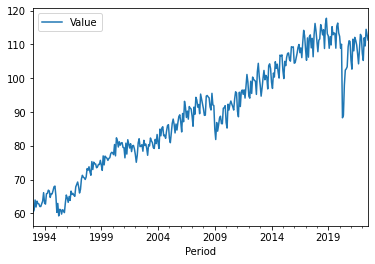

In [1142]:
#Plotting the time-series
df.plot( 'Period' , 'Value' )

**The result as we can see is a Non-Stationary series, we can infer this as it seems to have a growing trend over time, and a seasonality pattern, except for the 2020-2021 years where we see a high decrease, this might be due to the COVID-19 disease.**

**The Dr. A. Dorantes says that "a rule of thumb when we work with business variables such as volume sales, value sales, cost of good sold, etc is to transform the series into a stationary series." so we can work easily with the data**

**To do so, we should get the *first difference of the logarithm* of the variable, which is the percentage change of the variable from one period to other in continuously compounded and as a result we get a stationary time series 95% of the time.**

In [1143]:
#Getting the Logatithm of the IGAE variable Value 
df['ValueLn'] = np.log(df['Value'])
#Calculating the first difference of the log of the variable
#with a lag of 12 so we ensure is annual percentage change
df['AnnualDifference'] = df['ValueLn'].diff(periods=12)
#drop NaN generated and resetting index
df = df.dropna().reset_index(drop=True)
df

,Period,Value,ValueLn,AnnualDifference
0,1994-01-01,63.029268,4.143599,0.042483
1,1994-02-01,62.733156,4.138890,0.027647
2,1994-03-01,65.790275,4.186472,0.028476
3,1994-04-01,65.891716,4.188013,0.063042
4,1994-05-01,66.858802,4.202583,0.049767
...,...,...,...,...
338,2022-03-01,111.940152,4.717964,0.003661
339,2022-04-01,109.529866,4.696197,0.013414
340,2022-05-01,114.442424,4.740072,0.021001
341,2022-06-01,112.797501,4.725594,0.014522


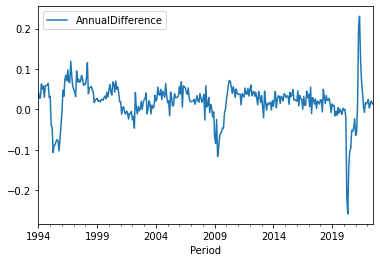

In [1144]:
df.plot( 'Period' , 'AnnualDifference' )

**By plotting the results, we can observe that it is hard to be sure if the serie is stationary or not, therefore is necessary to run a statistical test to help us know if the serie is stationary**

**To test stationarity we will use a test that creates a null hypotesis by assumming that the series is non stationary with a unit root (phi1=1), this test is called 'Dicky-Fuller test'.**

In [1145]:
#Setting the column to apply DickyFuller test
X = df['AnnualDifference']
#Using function from statsmodels API
result = adfuller(X, maxlag=12)
result

(-4.31567504789464,
 0.00041725264355974224,
 12,
 330,
 {'1%': -3.4503224123605194,
  '5%': -2.870338478726661,
  '10%': -2.571457612488522},
 -1454.5428263182732)

**Lets interpret the results**

- **1) In first place we have the critical value of the data: -4.315**

- **2) In second place the probability that null hypothesis will not be rejected(p-value): 0.0004 therefore we can reject the null hypotesis with a confidence greater than 95% and say that serie is stationary**

- **3) Third data point: 12 is the number of lags used in regression to determine t-statistic.**

- **4) In forth place we have the number of observations used in the analysis**

- **5) Fifth data point: {'1%': -3.45, '5%': -2.87, '10%': -2.57}: These are the T-values corresponding to the adfuller test. Since critical value -4.31<-2.5,-3.4,-2.8 (t-values at 1%,5%and 10% confidence intervals), null hypothesis can be rejected. So we can confirm that the data is stationarity**

#Auto Correlations and Partial Auto Correlations

**In order to identify the variables that have a significant autocorrelation we will run acf(for autocorrelation) and pacf(for partial autocorrelation) functions to graphically identify them**

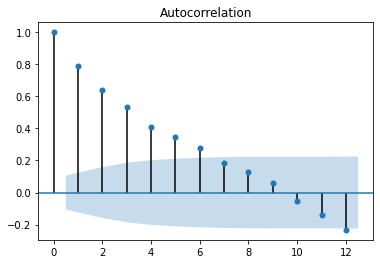

In [1146]:
plot_acf(df['AnnualDifference'],lags=12);

**Let's analize this graph:**
- **First we have the vertical lines, that represent the levels of autocorrelation between a given Y value in time (Y(t))**
- **Then we have the lags given, as is annual, the lags are 12**
- **In a blue shadow we have the 95% interval confidence of an existing autocorrelation**

**The autocorrelation represents the degree of similarity between a given time series and a lagged version of itself over successive time intervals**

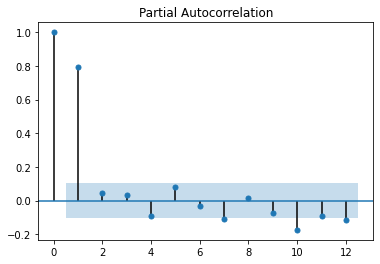

In [1147]:
plot_pacf(df['AnnualDifference'],lags=12);

**After plotting the partial autocorrelation we can see there is only one positive and significant autocorrelartion, and the following lag autocorrelations are mostly negative but not that significant, like the 7th, or 10th.**

**Get the partial autocorrelation plot is important, because it helps us to identify the number of auto regressive terms that the model will use. As we only have one lag partialy autocorrelated then we will start our model calibration with the p=1 and q=0 values.**

#Model Calibration

**As we have a seasonal non-stationary dataset, a SARIMA model will be calibrated. SARIMA stands for Seasonal Autoregressive Integrated Moving Average**
- **sarima(p, d, q, P, D, Q, #ofPeriods)**


- p: refers to the number of autoregressive (AR) terms. Usually this parameter is either 0,1 or 2.
- d: refers to how many first differences where needed to the series in order to make the series stationary. Usually this parameter is either 0 or 1.
- q: refers to the number of moving average (MA) terms in the model. Usually this parameter is either 0,1 or 2.
- P: refers to the number of SEASONAL autoregressive terms. Usually this parameter is either 0 or 1.
- D: refers to how many SEASONAL differences were needed to the series to make the series stationary. Usually this parameter is either 0 or 1.
- Q: refers to the number of SEASONAL moving average terms. Usually this parameter is either 0 or 1.
- #periods: refers to the number of periods in the year.

Information obtained from:
https://rpubs.com/cdorante/ec2004_w4

In [1148]:
#sarima(p, d, q, P, D, Q, #ofPeriods)
#Calibrating with the values obtained untill now (p, q, #periods)
sarimaModel = sm.tsa.SARIMAX(df['ValueLn'], 
                             order=(1,0,0), 
                             seasonal_order=(0,1,0,12), 
                             trend = 'c', #Constant to include fi0
                             simple_differencing=True #differencing is performed prior to estimation
                             ) 
fittedModel = sarimaModel.fit()

# Show the summary of results
print(fittedModel.summary())


                                     SARIMAX Results                                      
Dep. Variable:                       DS12.ValueLn   No. Observations:                  331
Model:             SARIMAX(1, 0, 0)x(0, 0, 0, 12)   Log Likelihood                 712.497
Date:                            Mon, 24 Oct 2022   AIC                          -1418.994
Time:                                    10:22:55   BIC                          -1407.588
Sample:                                         0   HQIC                         -1414.445
                                            - 331                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0039      0.002      2.545      0.011       0.001       0.007
ar.L1          0.7882      0.022   

**Fom this model we can see that the intercept, L1 and sigma 2 are statistically significant as their p-values are under the 0.05 threshold.**

**Now we will analize the white noise information given by SARIMAX results:**  
- **Ljung-Box (L1) (Q) is the LBQ test statistic at lag 1 is, the Prob(Q) is 0.01, and the p-value is 0.60. Since the probability is above 0.05, we can’t reject the null that the errors are white noise.**
- **Heteroscedasticity(H) tests that the error residuals have the same variance.We have a value of 2.23 and a p-value of 0.00, which means we can reject the null hypothesis and our residuals show variance.**
- **Jarque-Bera tests the null that the data is normally distributed, we see a test statistic of 2937.77 with a probability of 0, which means we reject the null hypothesis, and the data is not normally distributed. As part of the Jarque-Bera test, we see the distribution has a negative skew with -0.43 value and a 17.57 kurtosis.**


**We can also run some graphs to see how we can calibrate our model so there is no relationshipsbetween the variables and the values (white noise)**

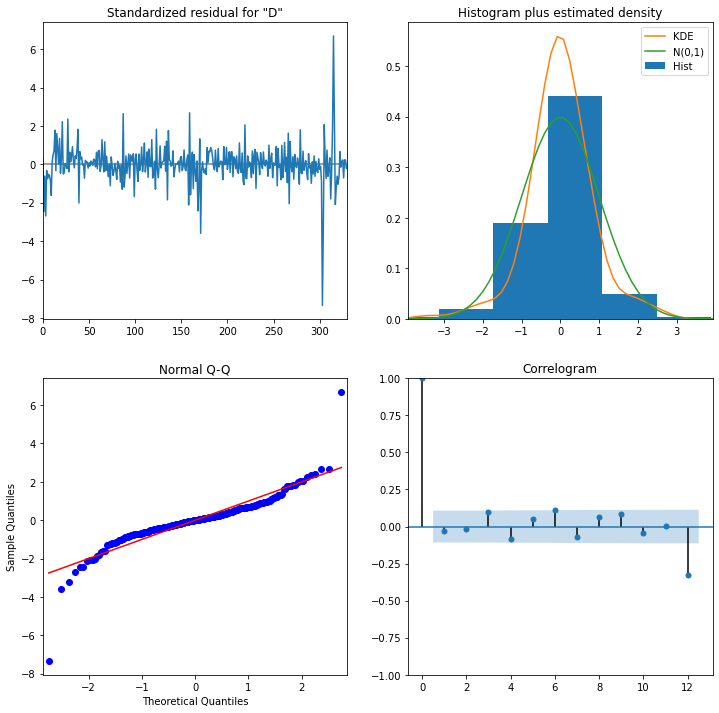

In [1149]:
fittedModel.plot_diagnostics(figsize=(12,12), lags=12)
plt.show()

- **Standarized Residual for "D" plot shows that most of the residual errors seem to fluctuate around a mean of zero and have a uniform variance, except for the first and the last values.**

- **Histogram plus estimated density plot suggest an slightly shrink normal distribution with mean zero.**

- **Normal Q-Q plot should have all the dots falling perfectly in the red line, but we have many significant deviations, and this imply the distribution is skewed.**

- **The Correlogram, shows the residual errors are strongly autocorrelated in lag 12**

**As we don't get the white noise we are going to continue calibrating our model, the first change will be a Q=0 P=1 configuration, as the correlogram has a negative residual correlation**

                                      SARIMAX Results                                       
Dep. Variable:                         DS12.ValueLn   No. Observations:                  331
Model:             SARIMAX(1, 0, 0)x(0, 0, [1], 12)   Log Likelihood                 774.971
Date:                              Mon, 24 Oct 2022   AIC                          -1541.943
Time:                                      10:22:57   BIC                          -1526.734
Sample:                                           0   HQIC                         -1535.877
                                              - 331                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0024      0.000      6.075      0.000       0.002       0.003
ar.L1          0.87

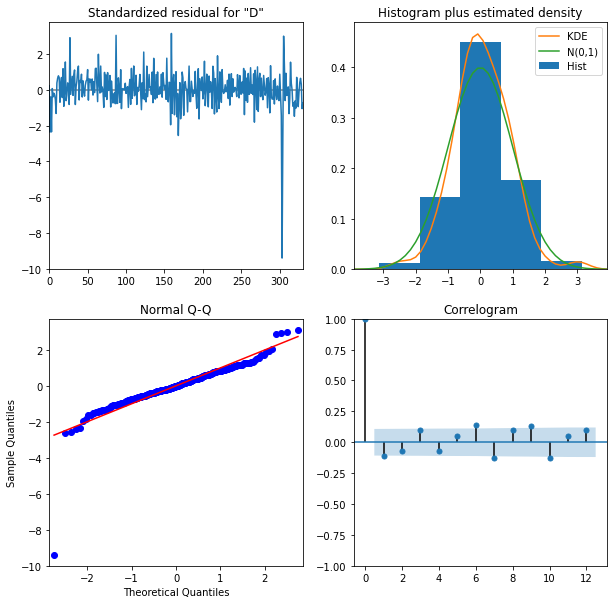

In [1150]:
#sarima(p, d, q, P, D, Q, #ofPeriods)
sarimaModel = sm.tsa.SARIMAX(df['ValueLn'], 
                             order=(1,0,0),
                             seasonal_order=(0,1,1,12), 
                             trend = 'c', #Constant
                             simple_differencing=True
                             ) 
fittedModel = sarimaModel.fit()

# Show the summary of results
print(fittedModel.summary())
fittedModel.plot_diagnostics(figsize=(10,10),lags=12)
plt.show()

**We can now see the Ljung-Box (L1) (Q) is 4.08, and the p-value is 0.04 as is less than 0.05 (the necessary to reject the null hupotesis), we can now say the errors are white noise.**

**To fully reject the hypotesis we can see in the correlogram, that there is no more a strong correlation, and now we are ready to make predictions with this model**

#Running predictions

**Predictions of 24 months from the last data (2022-07) are going to be done**

In [1151]:
#Getting DataFrame shape N(rows), M(columns)
N, M = df.shape 
#Create "predictions" Dataset 
dfPredictions = pd.DataFrame(fittedModel.predict(start=N, end=N+23)) #23 because in python it starts counting from 0.
#Getting the exponent so it goes back to the original scale (^2)
dfPredictions = np.exp(dfPredictions).reset_index(drop=True)
#Geting the past 24monts values to project the predictions
dfPredictions['pastValues'] = df["Value"].tail(24).reset_index(drop=True)
#Obtaining the predictions by adding pastValues + predicted_mean
dfPredictions['prediction'] = pd.DataFrame(dfPredictions['predicted_mean']+dfPredictions['pastValues'])
#Showing the prediction results
dfPredictions

,predicted_mean,pastValues,prediction
0,1.052191,102.742028,103.794219
1,1.048309,103.368393,104.416702
2,1.044907,109.270195,110.315102
3,1.041924,111.065784,112.107708
4,1.039308,110.848978,111.888286
5,1.037013,105.356736,106.393749
6,1.034999,102.666264,103.701263
7,1.033231,111.531140,112.564371
8,1.031678,108.070442,109.102120
9,1.030315,112.064049,113.094364


**Now we are ready to plot our predictions 24monts from now**

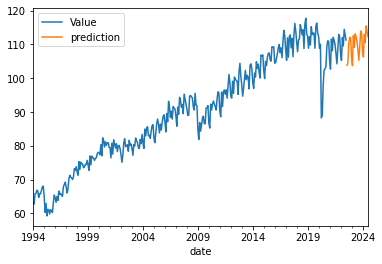

In [1152]:
#Creating prediction dataset to plot the predictions
pred = pd.DataFrame(dfPredictions['prediction'])
#creating period of time starting in first prediction date and finishing 2024-07 (24 months after)
pred['date'] = pd.date_range(start='2022-08', periods=24, freq='M')
#converting to datetime to work with it
pred['date'] = pd.to_datetime(pred['date'])
#Plotting Results
ax = df.plot('Period' , 'Value' )
pred.plot('date' , 0 ,ax=ax)


**In blue, we can see the dataset history and in orange we can see the predicted results. In the X axis we have the periods in years and in the Y axis we have the IGAE value indicators**

**It seems that is going to continue growing in the next two years, unless there is another external shock that makes it go down, like the 2020 pandemic. Those are errors that can't be predicted and could extremely affect the predictions. But in a perfect scenario, the Mexican IGAE indicator would look like the orange plot in time.**

----

#References:

- **Dorantes Dosamantes, C. A. (Aug 31, 2021). Financial Econometrics II. Accesed Oct 18, 2022, from https://rpubs.com/cdorante/ec2004_w4**
- **Dorantes Dosamantes, C. A. (Aug 24, 2021). Financial Econometrics II. Accesed Oct 16, 2022, from https://rpubs.com/cdorante/ec2004_w3**
- **Team, T. A. I. (May 12,2022). Time Series Forecasting with ARIMA Models In Python. Towards AI. Accesed Oct 19, 2022, from https://towardsai.net/p/l/time-series-forecasting-with-arima-models-in-python-part-2**
- **Brownlee J.(Jan 6, 2017). Accesed Oct 21, 2022, from https://machinelearningmastery.com/visualize-time-series-residual-forecast-errors-with-python/**